In [18]:
!pip install blitz-bayesian-pytorch


In [19]:
import warnings
warnings.filterwarnings('ignore')


In [20]:
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
from torch.utils.data import TensorDataset, DataLoader
from matplotlib.pyplot import scatter, figure
from scipy import stats
from numpy.ma.core import outer
from sys import stderr


In [21]:
start = -7
end = 7
n = 300
batch_size = 16

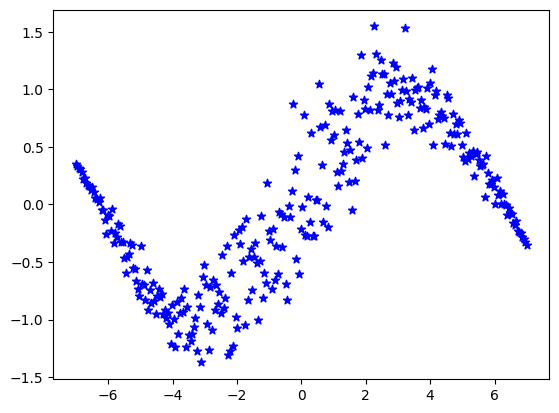

In [22]:
def sample_dataset(start, end, n):
    np.random.seed(0)
    x = np.linspace(start, end, n)
    sample_mean = [math.sin(i/2) for i in x]

    sample_var = [abs((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs(random_state=0)
    return x, y

x_train, y_train = sample_dataset(start, end, n)
scatter(x_train, y_train, c="blue", marker="*")

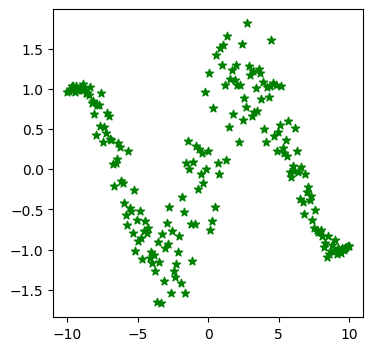

In [23]:
figure(figsize=(4, 4))
# Not exactely the same distribution, but works for now
x_test, y_test = sample_dataset(-10, 10, 200)
scatter(x_test, y_test, c="green", marker="*")

In [24]:

# Train
tensor_x = torch.Tensor(x_train).unsqueeze(1)
tensor_y = torch.Tensor(y_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Test
tensor_x_test = torch.Tensor(x_test).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [25]:
class MCDO(nn.Module):
    def __init__(self):
        super(MCDO, self).__init__()
        hidden_size = 61

        # We only have 1 input feature
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        h = self.dropout(torch.relu(self.fc1(x)))
        h = self.dropout(torch.relu(self.fc2(h)))
        out = self.out(h)
        return out



In [26]:
model = MCDO()
print(model)
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

MCDO(
  (fc1): Linear(in_features=1, out_features=61, bias=True)
  (fc2): Linear(in_features=61, out_features=61, bias=True)
  (out): Linear(in_features=61, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
Params: 3966


In [27]:
def make_plot_mcdo(model, samples = 50):
    # Keep dropout active!
    model.train()
    preds = [model(tensor_x_test) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0).detach().numpy()
    stds =  preds.std(axis=0).detach().numpy()
    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot train data on top
    scatter(x_train, y_train, c="green", marker="*", alpha=0.1)
    plt.show()

In [30]:
def MLE_mcdo():
  criterion = torch.nn.MSELoss()
  model = MCDO()
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  model.to(device)

  for epoch in range(150):
    model.train()
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(y, out)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)

             # Sample MC Dropout predictions
             outs = []
             for i in range(10):
                  model.train()
                  out = model(x)
                  outs.append(out)

             # Take mean prediction
             out = sum(outs)/len(outs)
             all_test_losses.append(criterion(y, out).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)

  make_plot_mcdo(model)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")

  return loss, test_loss


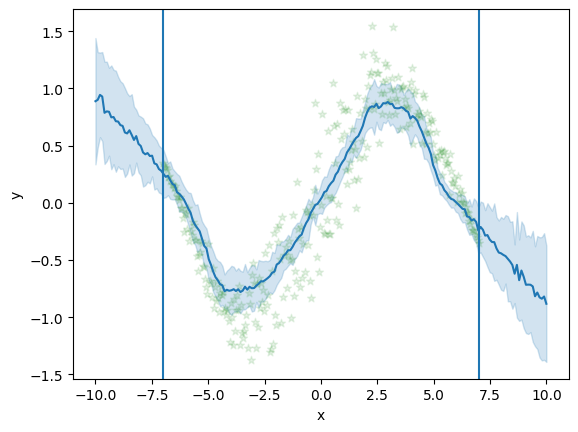

Epoch 149 | batch train loss: 0.07603120058774948 | test loss: 0.18256806181027338


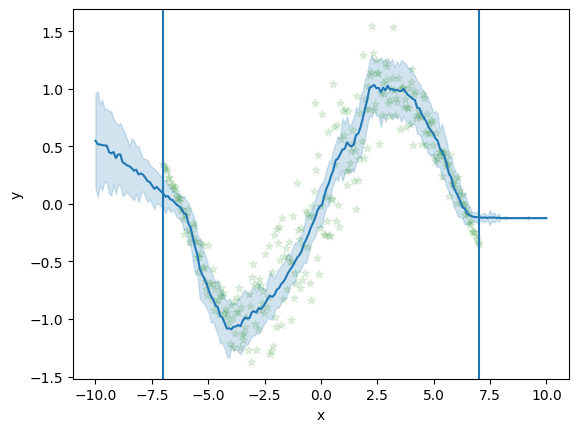

Epoch 149 | batch train loss: 0.06995514780282974 | test loss: 0.23702810647395942


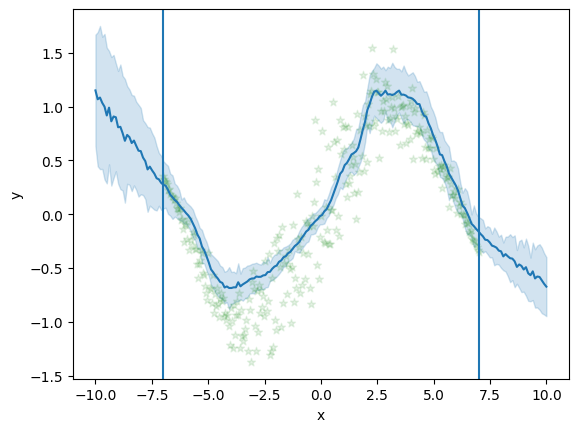

Epoch 149 | batch train loss: 0.1376297026872635 | test loss: 0.17640194239524695


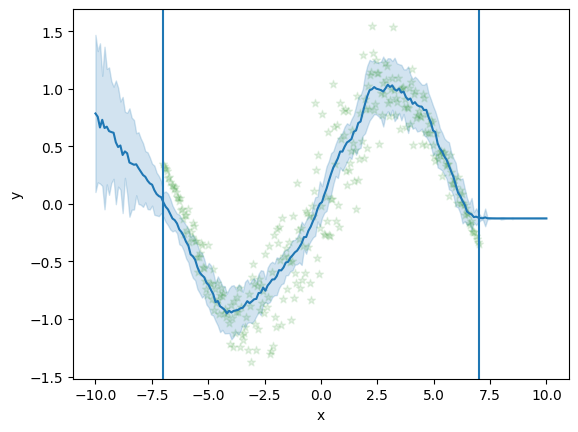

Epoch 149 | batch train loss: 0.0893736481666565 | test loss: 0.25377369156250584


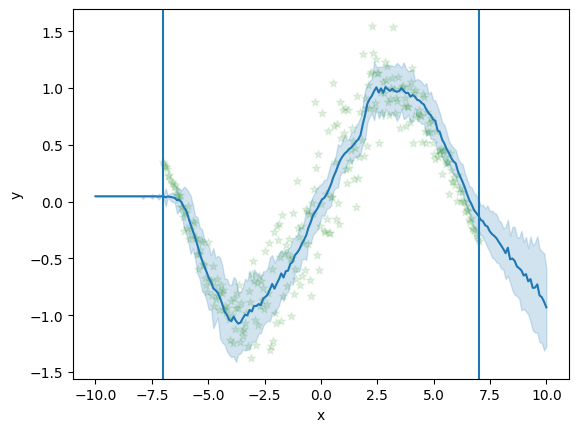

Epoch 149 | batch train loss: 0.06477595120668411 | test loss: 0.2854376412354983


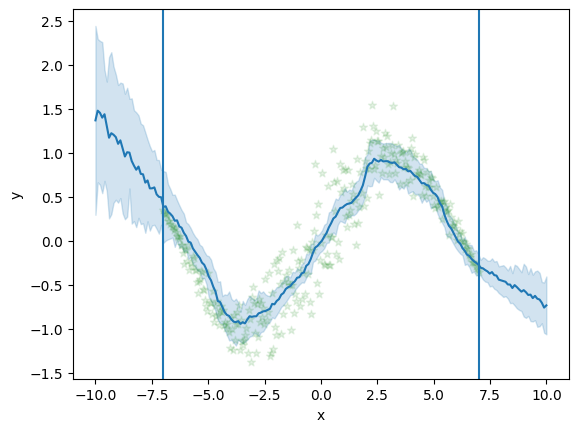

Epoch 149 | batch train loss: 0.049533236771821976 | test loss: 0.1767015875532077


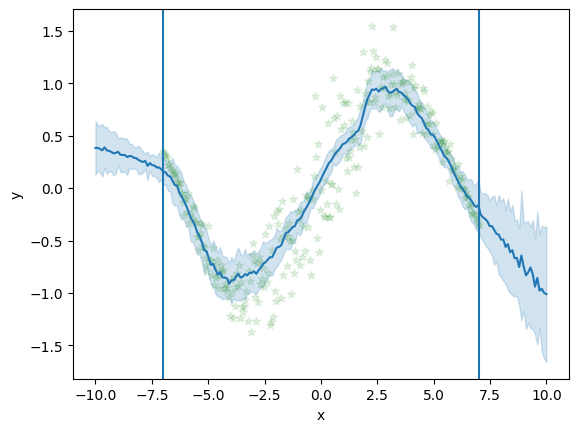

Epoch 149 | batch train loss: 0.13335081934928894 | test loss: 0.261873450416785


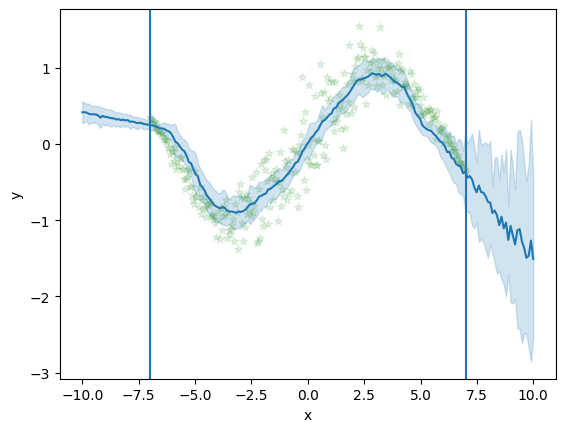

Epoch 149 | batch train loss: 0.1042017936706543 | test loss: 0.18309592914122802


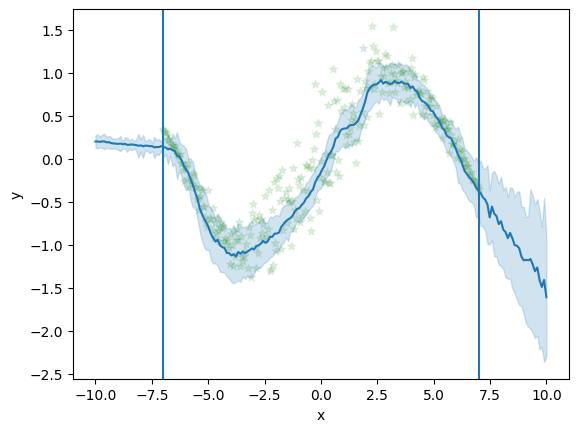

Epoch 149 | batch train loss: 0.104974664747715 | test loss: 0.23486600529689056


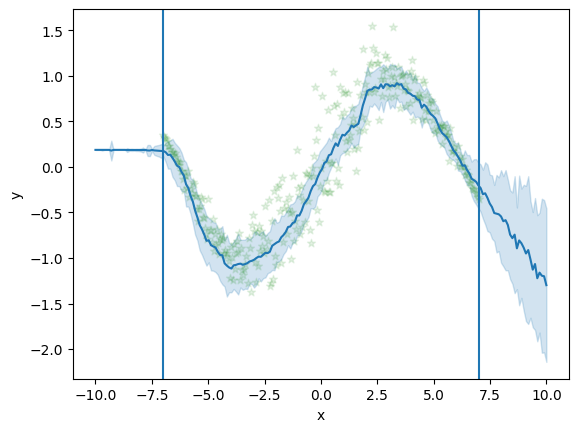

Epoch 149 | batch train loss: 0.05888519063591957 | test loss: 0.2488985795241136


In [31]:
train_losses=[]
test_losses=[]

for i in range(10):
  tr_loss,test_loss = MLE_mcdo()
  train_losses.append(tr_loss)
  test_losses.append(test_loss)


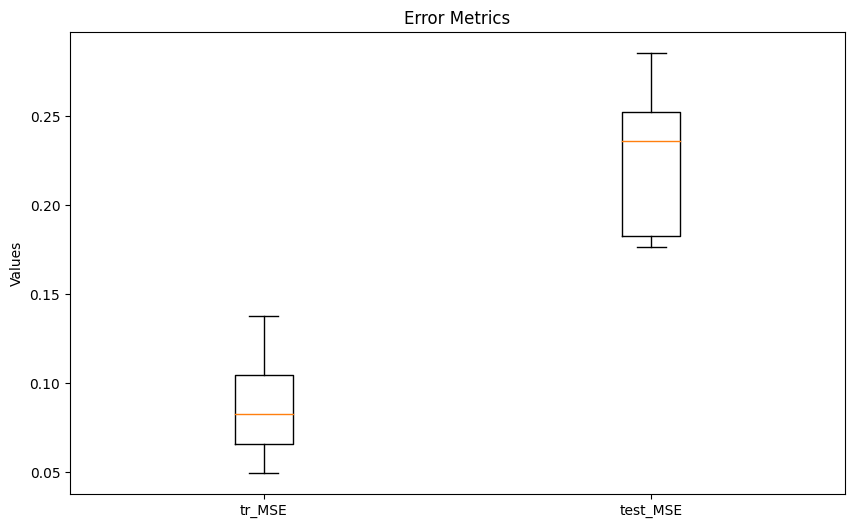

In [32]:
# Extract numerical values from the tensors and remove grad_fn
tr_loss_values= [tensor.item() for tensor in train_losses]
test_loss_values=test_losses

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create box plots for each dataset
box_plot_data = [tr_loss_values, test_loss_values]
box_labels = ['tr_MSE', 'test_MSE']

ax.boxplot(box_plot_data, labels=box_labels)

# Add labels and title

ax.set_ylabel('Values')
ax.set_title('Error Metrics')

# Show the plot
plt.show()


In [33]:
# Create a DataFrame from the lists
data = {
    'Training Loss': tr_loss_values,
    'Testing Loss': test_loss_values,

}

num_columns = len(data)

column_names = ['Training Loss','Testing Loss']

# Create a DataFrame with dynamic column names
df = pd.DataFrame(data, columns=column_names)
df.index += 1
# Display the DataFrame as a table
print(df)

    Training Loss  Testing Loss
1        0.076031      0.182568
2        0.069955      0.237028
3        0.137630      0.176402
4        0.089374      0.253774
5        0.064776      0.285438
6        0.049533      0.176702
7        0.133351      0.261873
8        0.104202      0.183096
9        0.104975      0.234866
10       0.058885      0.248899
